In [19]:
import pandas as pd
import networkx as nx
import igviz as ig

In [20]:
characters_df = pd.read_csv('../data/ChristmasCarol/processed_characters.csv')
characters_df

,Unnamed: 0,COREF,start_token,end_token,prop,cat,text,character_name
0,0,14,0,3,PROP,PER,MARLEY 'S GHOST Marley,MARLEY 'S GHOST Marley
1,6,20,41,41,PROP,PER,Scrooge,Mr. Ebenezer Scrooge
2,7,20,46,46,PROP,PER,Scrooge,Mr. Ebenezer Scrooge
3,8,20,56,56,PRON,PER,he,Mr. Ebenezer Scrooge
4,9,20,60,60,PRON,PER,his,Mr. Ebenezer Scrooge
...,...,...,...,...,...,...,...,...
1970,4729,58,35876,35876,PRON,PER,He,poor Tiny Tim
1971,4730,66,35882,35882,PROP,PER,Spirits,THE SPIRITS The Phantom
1972,4731,58,35901,35901,PRON,PER,him,poor Tiny Tim
1973,4732,58,35903,35903,PRON,PER,he,poor Tiny Tim


In [21]:
tokens_df = pd.read_csv('../data/ChristmasCarol/character-tagging/ChristmasCarol.tokens', delimiter='\t')
tokens_df

,paragraph_ID,sentence_ID,token_ID_within_sentence,token_ID_within_document,word,lemma,byte_onset,byte_offset,POS_tag,fine_POS_tag,dependency_relation,syntactic_head_ID,event
0,0,0,0,0,MARLEY,MARLEY,0,6,PROPN,NNP,compound,3,O
1,0,0,1,1,'S,'s,6,8,PART,POS,compound,2,O
2,0,0,2,2,GHOST,GHOST,9,14,PROPN,NNP,compound,3,O
3,1,0,3,3,Marley,Marley,17,23,PROPN,NNP,nsubj,4,O
4,1,0,4,4,was,be,24,27,AUX,VBD,ROOT,4,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35942,712,1806,10,35942,Us,we,157762,157764,PRON,PRP,dobj,35941,O
35943,712,1806,11,35943,",",",",157764,157765,PUNCT,",",punct,35941,O
35944,712,1806,12,35944,Every,every,157766,157771,DET,DT,det,35945,O
35945,712,1806,13,35945,One,one,157772,157775,NUM,CD,npadvmod,35941,O


In [22]:
# Paragraph based network

characters_paragraph_mention_df = characters_df.copy()
characters_paragraph_mention_df['paragraph'] = characters_paragraph_mention_df.start_token.map(
    lambda x: tokens_df.iloc[x].paragraph_ID
)
characters_paragraph_mention_df

,Unnamed: 0,COREF,start_token,end_token,prop,cat,text,character_name,paragraph
0,0,14,0,3,PROP,PER,MARLEY 'S GHOST Marley,MARLEY 'S GHOST Marley,0
1,6,20,41,41,PROP,PER,Scrooge,Mr. Ebenezer Scrooge,1
2,7,20,46,46,PROP,PER,Scrooge,Mr. Ebenezer Scrooge,1
3,8,20,56,56,PRON,PER,he,Mr. Ebenezer Scrooge,1
4,9,20,60,60,PRON,PER,his,Mr. Ebenezer Scrooge,1
...,...,...,...,...,...,...,...,...,...
1970,4729,58,35876,35876,PRON,PER,He,poor Tiny Tim,712
1971,4730,66,35882,35882,PROP,PER,Spirits,THE SPIRITS The Phantom,712
1972,4731,58,35901,35901,PRON,PER,him,poor Tiny Tim,712
1973,4732,58,35903,35903,PRON,PER,he,poor Tiny Tim,712


In [41]:
paragraph_windows = 6
paragraphs_per_window = characters_paragraph_mention_df.paragraph.max() // paragraph_windows

sizes = paragraph_windows * [paragraphs_per_window]
for i in range(characters_paragraph_mention_df.paragraph.max() - sum(sizes)):
    sizes[i] += 1

In [42]:
graphs = []

G = nx.Graph()

curr_graph = 0

for paragraph, sub_df in characters_paragraph_mention_df.groupby(characters_paragraph_mention_df.paragraph):
    
    if paragraph > sizes[curr_graph] + sum(sizes[:curr_graph]):
        graphs.append(G)
        curr_graph += 1
        G = nx.Graph()
    
    if sub_df.character_name.unique().size == 1:
        continue
    
    pairs = []
    for i, name in enumerate(sub_df.character_name.unique()):
        
        if name not in G.nodes:
            G.add_node(name, connections=sub_df.character_name.unique().size - 1, name=name)
        else:
            G.nodes[name]['connections'] += sub_df.character_name.unique().size - 1

        for o_name in sub_df.character_name.unique()[i + 1:]:
            
            if o_name not in G.nodes:
                G.add_node(o_name, connections=0, name=o_name)
            if (name, o_name) not in G.edges:
                G.add_edge(name, o_name, weight=1)
            else:
                G.edges[name, o_name]['weight'] += 1

In [43]:
window = 3

color_list = []
sizing_list = []

G = graphs[window]

for node in G.nodes():
    size_and_color = G.nodes[node]['connections']

    color_list.append(size_and_color)
    sizing_list.append(size_and_color)

ig.plot(
    G,
    title=f"Window {window} Social Network",
    layout="spring",
    size_method=sizing_list, # Makes node sizes the size of the "prop" property
    color_method=color_list, # Colors the nodes based off the "prop" property and a color scale,
    edge_label="weight", # Display the "edge_prop" attribute on the edge
    edge_label_position="bottom center", # Display the edge label below the edge
    node_text=['connections'],
    node_label="name"
)

C:\Users\decla\AppData\Local\Temp\ipykernel_4648\749952359.py:14: DeprecationWarning:

Argument `titlefont_size` is deprecated and will be removed in 0.6.0.



FigureWidget({
    'data': [{'hoverinfo': 'text',
              'line': {'color': '#888', 'width': 1},
              'mode': 'lines+text',
              'text': [],
              'type': 'scatter',
              'uid': '3459162c-371c-4162-96e1-6931e9198cb8',
              'x': [0.2127735829754881, -0.07424095350488857, None,
                    0.2127735829754881, 0.34848291286033506, None,
                    0.2127735829754881, 0.5320054192859263, None,
                    -0.07424095350488857, 0.34848291286033506, None,
                    -0.07424095350488857, 0.5320054192859263, None,
                    -0.07424095350488857, -0.6326970672596238, None,
                    -0.07424095350488857, 0.19876539417620384, None,
                    -0.07424095350488857, 0.4204170679013332, None,
                    -0.07424095350488857, 0.6994788801259418, None,
                    -0.07424095350488857, -0.12870964403179613, None,
                    -0.07424095350488857, -0.57627559252892

In [44]:
# Ego Networks

character_of_interest = 'Mr. Ebenezer Scrooge'

for graph in graphs:
    remove_nodes = []
    for node in graph.nodes:
        if node == character_of_interest:
            continue

        if not (node, character_of_interest) in graph.edges:
            for _, other_node in graph.edges(node):
                graph.nodes[other_node]['connections'] -= graph.edges[node, other_node]['weight']
            remove_nodes.append(node)
    for node in remove_nodes:
        graph.remove_node(node)

In [62]:
window = 3

color_list = []
sizing_list = []

G = graphs[window]

for node in G.nodes():
    size_and_color = G.nodes[node]['connections']

    color_list.append(size_and_color)
    sizing_list.append(size_and_color)

ig.plot(
    G,
    title=f"Window {window + 1} {character_of_interest} Ego Social Network",
    layout="spring",
    size_method=sizing_list, # Makes node sizes the size of the "prop" property
    color_method=color_list, # Colors the nodes based off the "prop" property and a color scale,
    edge_label="weight", # Display the "edge_prop" attribute on the edge
    edge_label_position="bottom center", # Display the edge label below the edge
    node_text=['connections'],
    node_label="name"
)

C:\Users\decla\AppData\Local\Temp\ipykernel_4648\2250379803.py:14: DeprecationWarning:

Argument `titlefont_size` is deprecated and will be removed in 0.6.0.



FigureWidget({
    'data': [{'hoverinfo': 'text',
              'line': {'color': '#888', 'width': 1},
              'mode': 'lines+text',
              'text': [],
              'type': 'scatter',
              'uid': '91221493-8572-457b-b5f5-1ebe6e5fe015',
              'x': [-0.34834648041887717, -0.1108109629364567, None,
                    -0.34834648041887717, 0.29446303591617534, None,
                    -0.34834648041887717, 0.2689431080164455, None,
                    -0.1108109629364567, 0.29446303591617534, None,
                    -0.1108109629364567, 0.2689431080164455, None,
                    -0.1108109629364567, -0.7509220453057424, None,
                    -0.1108109629364567, 0.483319537685751, None,
                    -0.1108109629364567, 0.7444224118208237, None,
                    -0.1108109629364567, 0.6236461117779426, None,
                    -0.1108109629364567, 0.22790812073885056, None,
                    -0.1108109629364567, -0.432622837294911, Non

In [46]:
from collections import defaultdict

per_window_importances = {}


for i, window_graph in enumerate(graphs):
    for _, other_char in window_graph.edges(character_of_interest):
        if other_char not in per_window_importances:
            per_window_importances[other_char] = len(graphs) * [0]

        per_window_importances[other_char][i] = window_graph.nodes[other_char]['connections']

sorted_keys = sorted(per_window_importances, key=lambda x: sum(per_window_importances[x]), reverse=True)

In [47]:
top_10_characters = {key: per_window_importances[key] for key in sorted_keys[:10]}

In [48]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

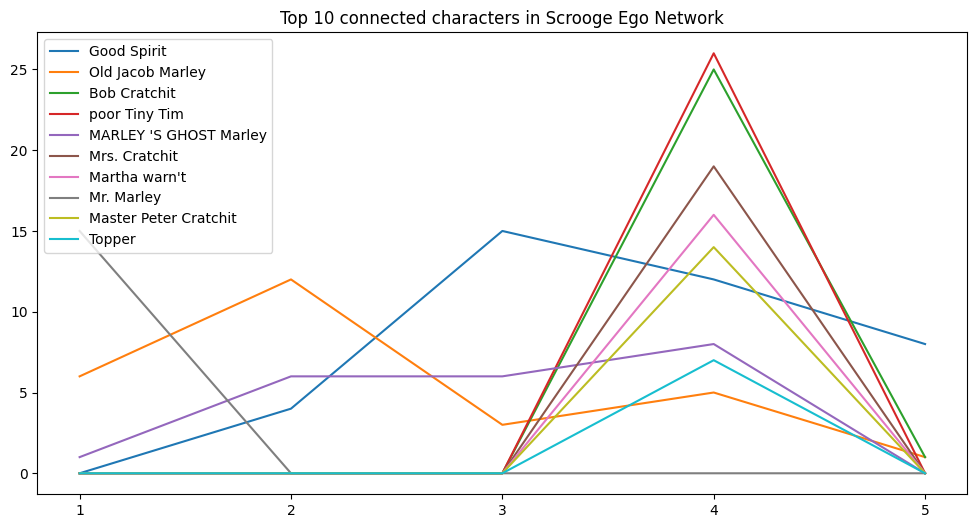

In [61]:
axis = ['1', '2', '3', '4', '5']

for character, counts in top_10_characters.items():
    character_short_name = ' '.join(character.split()[:4])
    plt.plot(axis, counts, label=character_short_name)

plt.legend()
plt.title('Top 10 connected characters in Scrooge Ego Network')
plt.rcParams['figure.figsize'] = (12., 6.)
plt.savefig('scrooge_top_10_chars.png')
plt.show()

In [14]:
graphs[0].nodes

NodeView(('Mr. Ebenezer Scrooge', 'Old Jacob Marley', 'Mr. Marley'))

In [39]:
len(graphs)

4